In [51]:
import pandas as pd
import cv2
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from torch import nn, optim
import time
from tempfile import TemporaryDirectory
import os

device = torch.device('cuda:0')

In [52]:
rows = pd.read_csv('content/outFrames/content.csv')
rows['class'] = rows['class'].fillna('None')

In [53]:
frames = { 'Train': [], 'Test': [] }
class_idxs =  { 'UD': 0, 'WF': 1, 'None': 2 } 
class_names = [ 'UD', 'WF', 'None' ]
main_ndarray = np.load('content/frame_array.npy')
main_ndarray = main_ndarray.astype('float32')

# BGR->RGB
main_ndarray = np.stack([
    main_ndarray[:, :, :, 2],
    main_ndarray[:, :, :, 1],
    main_ndarray[:, :, :, 0],
], axis=-1)
# (H,W,C) -> (C,W,H)
main_ndarray = main_ndarray.transpose((0, 3, 1, 2))
# Normalize
main_ndarray = (main_ndarray - 128.0) / 128.0 

grouped = rows.groupby(['video_name', 'interval', 'class', 'type'], as_index=False)
count = 0
skip = 16
# target_size = 32
target_size = 3
for grp, values in grouped:
    if len(values) < target_size:
        continue

    # TODO: Can get more sample if values is larger than target_size frame
    idxs = []
    for idx, row in values.iterrows():
        idxs.append(idx)

    i = 0
    while i+target_size <= len(idxs):
        frame_ndarray = main_ndarray[idxs[i:i+target_size],]
        i+=skip
        frames[grp[3]].append((frame_ndarray, class_idxs[grp[2]]))

In [54]:
dataloaders = {
    'Train': torch.utils.data.DataLoader(frames['Train'], batch_size=4, shuffle=True, num_workers=4),
    'Test': torch.utils.data.DataLoader(frames['Test'], batch_size=4, shuffle=True, num_workers=4),
}

dataset_sizes = {
    'Train': len(frames['Train']),
    'Test': len(frames['Test']), 
}

print(f'Size of training set {dataset_sizes["Train"]}')
print(f'Size of testing set {dataset_sizes["Test"]}')

Size of training set 276
Size of testing set 100


In [55]:
label_count = {}
for _, k in frames["Train"]:
    if class_names[k] not in label_count:
        label_count[class_names[k]] = 0
    label_count[class_names[k]] += 1

label_count

{'None': 100, 'UD': 83, 'WF': 93}

In [56]:
label_count = {}
for _, k in frames["Test"]:
    if class_names[k] not in label_count:
        label_count[class_names[k]] = 0
    label_count[class_names[k]] += 1

label_count

{'None': 28, 'WF': 43, 'UD': 29}

In [57]:

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


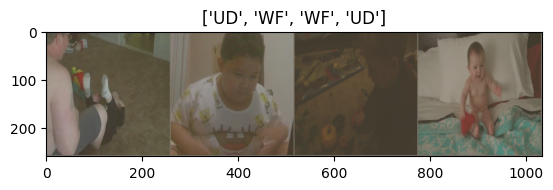

In [58]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['Train']))
inputs = inputs[:,0]

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

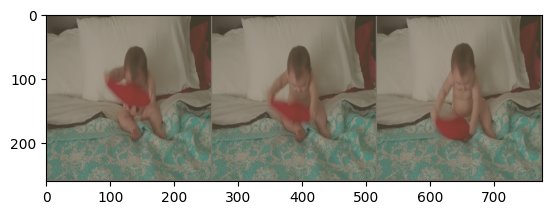

In [59]:
# Get a frame
inputs, classes = next(iter(dataloaders['Train']))
inputs = inputs[0,:]

# Make a grid from frame
out = torchvision.utils.make_grid(inputs)

imshow(out)

In [60]:
def train_model(model, criterion, optimizer, scheduler, transform=None, num_epochs=25):
    since = time.time()
    losses = {'Train': [], 'Test': []}
    accuracies = {'Train': [], 'Test': []}

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = './best_model_params.pt'

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['Train', 'Test']:
                if phase == 'Train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    if transform != None:
                        inputs = transform(inputs).to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'Train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'Train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'Train':
                   scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                losses[phase].append(float(epoch_loss))
                accuracies[phase].append(float(epoch_acc))

                # deep copy the model
                if phase == 'Test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            # Stop early on two consecutive higher test loss
            # if len(losses['Test']) > 2 and losses['Test'][-1] > losses['Test'][-2] and losses['Test'][-2] > losses['Test'][-3]:
            #  break

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))

    _, axes = plt.subplots(2, 1)
    axes[0].plot(losses['Train'], label='Train loss')
    axes[0].plot(losses['Test'], label='Test loss')
    axes[0].legend()
    
    axes[1].plot(accuracies['Train'], label='Train accuracy')
    axes[1].plot(accuracies['Test'], label='Test accuracy')
    axes[1].legend()
   
    return model

In [64]:
import torch.nn as nn
import torchvision.models as models

class VideoModel(nn.Module):

    def __init__(self, num_classes, r2plus1d_pretrained=True):
        super(VideoModel, self).__init__()

        # Load the pre-trained R(2+1)D-18 model
        self.r2plus1d = models.video.r2plus1d_18(pretrained=r2plus1d_pretrained)

        # Modify the classification layer to match the number of classes in your dataset
        self.r2plus1d.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.r2plus1d(x)
        return x
        
import torch.optim as optim

# Instantiate your VideoModela
video_model = VideoModel(num_classes=3, r2plus1d_pretrained=True)

# Define different learning rates for different parts of the model
learning_rate = 0.001
#lower_lr_factor = 0.1  # Factor by which to multiply the learning rate for earlier layers
lower_lr_factor = 0.01
# Separate parameters into two groups: R2Plus1D layers and fc layer
r2plus1d_params = [param for name, param in video_model.r2plus1d.named_parameters() if 'fc' not in name]
fc_params = [param for name, param in video_model.r2plus1d.named_parameters() if 'fc' in name]

# Specify different learning rates for different parts of the model
optimizer = optim.Adam([
    {'params': r2plus1d_params, 'lr': learning_rate},
    {'params': fc_params, 'lr': learning_rate * lower_lr_factor}
])

# During training, use this optimizer to update the entire model
# with different learning rates for different parts



/home/amirul/pythonvenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/amirul/pythonvenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R2Plus1D_18_Weights.KINETICS400_V1`. You can also use `weights=R2Plus1D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [65]:
import torchvision.transforms.v2 as transforms

num_classes = 3
model_ft = VideoModel(num_classes=num_classes)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=5e-4, weight_decay=1e-4)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

model_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Epoch 0/29
----------
Train Loss: 0.6850 Acc: 0.6594
Test Loss: 2.0802 Acc: 0.3000
Epoch 1/29
----------
Train Loss: 0.6815 Acc: 0.7065
Test Loss: 2.2546 Acc: 0.2900
Epoch 2/29
----------
Train Loss: 0.6923 Acc: 0.6775
Test Loss: 2.1631 Acc: 0.3400
Epoch 3/29
----------
Train Loss: 0.7037 Acc: 0.6703
Test Loss: 2.3046 Acc: 0.3200
Epoch 4/29
----------
Train Loss: 0.7212 Acc: 0.6739
Test Loss: 2.1967 Acc: 0.3200
Epoch 5/29
----------
Train Loss: 0.6992 Acc: 0.7174
Test Loss: 2.4257 Acc: 0.2900
Epoch 6/29
----------
Train Loss: 0.7141 Acc: 0.6522
Test Loss: 2.4606 Acc: 0.3200
Epoch 7/29
----------
Train Loss: 0.6935 Acc: 0.6812
Test Loss: 2.0936 Acc: 0.3300
Epoch 8/29
----------
Train Loss: 0.6745 Acc: 0.7138
Test Loss: 1.9758 Acc: 0.2900
Epoch 9/29
----------
Train Loss: 0.7345 Acc: 0.6232
Test Loss: 2.3936 Acc: 0.3100
Epoch 10/29
----------
Train Loss: 0.7388 Acc: 0.6522
Test Loss: 2.1492 Acc: 0.3500
Epoch 11/29
----------
Train Loss: 0.7189 Acc: 0.6413
Test Loss: 2.0383 Acc: 0.3300
Ep

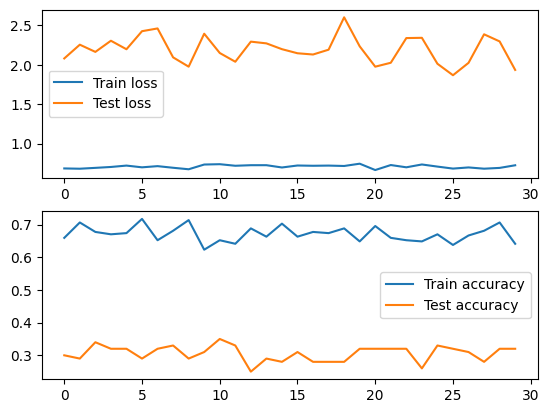

In [182]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, transform=model_transform,
                       num_epochs=30)

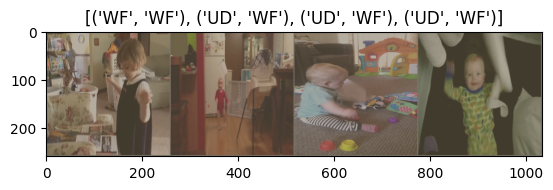

In [183]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['Test']))

inferred_class = model_ft(inputs.to(device))

predicted_class = list(torch.argmax(inferred_class, dim=-1))
inputs = inputs[:,0]

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[(class_names[classes[x]], class_names[predicted_class[x]]) for x in range(len(classes))])

In [184]:
from sklearn.metrics import confusion_matrix

true_label = []
predicted_label = []
for input, label in dataloaders['Test']:
    true_label = true_label + label.tolist()
    pred = model_ft(model_transform(input).to(device))
    pred = pred.argmax(-1)
    predicted_label = predicted_label + pred.tolist()


In [185]:
from sklearn.metrics import confusion_matrix

true_label = []
predicted_labels = []

model_ft.eval()  # Set the model to evaluation mode

with torch.no_grad():  # Disable gradient computation during inference
    for inputs, labels in dataloaders['Test']:
        true_label.extend(labels.tolist())
        preds = model_ft(model_transform(inputs).to(device))
        preds = preds.argmax(dim=1)
        predicted_labels.extend(preds.tolist())

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_label, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[18  1 10]
 [29  0 14]
 [15  0 13]]


In [186]:
def get_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

# Evaluate accuracy on the test set
test_accuracy = get_accuracy(model_ft, dataloaders['Test'])
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Test Accuracy: 45.00%
